The real time detection will be done using a different model and the JSON file with the current model and the weights of the neural network we will create.
a 70-100% success rate of facial recognition is satisfactory because the real-time app will use several pictures and the common emotion recognition resault to decide the emotion - in this current run we have reached 88%


In April 2023 the access to AffectNet Data set will be restored and the success rate can be reached to over 90% in the next few days we will try KDEF dataset for better results

#TO-DO list

1. we need to increase amount of photo emotion like angry,fear,disgust to make the data set more balanced.
2. fix comments and rearrange the file 

# First Section

The first section of the code manipulates the dataset of the faces photos into lists, and builds the model
all with imports at the beginning  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd                       #reading, writing and manipulating the data (using tables)
import numpy as np                        #Library for linear algebra and some probabiltity (raw data)
import tensorflow as tf                       
from keras.models import Sequential       #To create the sequential layer
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image             #used for image classification
from keras.preprocessing.image import ImageDataGenerator  #used to expand the training dataset in order to improve the performance and ability of the model to generalize
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import SGD, Adam          #To use the optimizer
from keras.utils import np_utils  



In [ ]:
# Load arrays from disk
combined_X = np.load('/content/drive/MyDrive/Emotion Detection/combined_X.npy')
combined_y = np.load('/content/drive/MyDrive/Emotion Detection/combined_y.npy')

In [ ]:
print(len(combined_X))
print(len(combined_y))

129949
129949


#Creating the model

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization,Activation
from keras.regularizers import l2
from keras import backend as K
from keras.layers import Lambda
import numpy as np
from keras.layers import Lambda


# add Gaussian noise to input images
def add_noise(x, noise_level):
    noise = np.random.normal(loc=0, scale=noise_level, size=x.shape)
    return x + noise

# define noise level
    noise_level = 0.1


# add noise layer to model
input_layer = Input(shape=input_shape)
noise_layer = Lambda(lambda x: add_noise(x, noise_level))(input_layer)



conv1 = Conv2D(num_filters, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(noise_layer)

def dense_block(x, num_layers, growth_rate, dropout_rate=0.2, weight_decay=1e-4):
    for i in range(num_layers):
        bn1 = BatchNormalization(axis=3, gamma_regularizer=l2(weight_decay))(x)
        relu1 = Activation('relu')(bn1)
        conv1 = Conv2D(growth_rate, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(relu1)
        if dropout_rate:
            conv1 = Dropout(dropout_rate)(conv1)
        x = concatenate([x, conv1])
    return x

def transition_layer(x, compression_factor=0.5, dropout_rate=0.2, weight_decay=1e-4):
    bn1 = BatchNormalization(axis=3, gamma_regularizer=l2(weight_decay))(x)
    relu1 = Activation('relu')(bn1)
    num_filters = int(x.shape.as_list()[-1] * compression_factor)
    conv1 = Conv2D(num_filters, (1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(relu1)
    if dropout_rate:
        conv1 = Dropout(dropout_rate)(conv1)
    pool1 = AveragePooling2D((2,2), strides=(2,2))(conv1)
    return pool1

def DenseNet(input_shape, depth=40, num_classes=7, growth_rate=12, compression_factor=0.5, dropout_rate=0.2, weight_decay=1e-4):
    num_layers = (depth - 4) // 3
    num_filters = growth_rate * 2

    inputs = Input(shape=input_shape)

    conv1 = Conv2D(num_filters, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(inputs)

    dense1 = dense_block(conv1, num_layers, growth_rate, dropout_rate, weight_decay)
    trans1 = transition_layer(dense1, compression_factor, dropout_rate, weight_decay)

    dense2 = dense_block(trans1, num_layers, growth_rate, dropout_rate, weight_decay)
    trans2 = transition_layer(dense2, compression_factor, dropout_rate, weight_decay)

    dense3 = dense_block(trans2, num_layers, growth_rate, dropout_rate, weight_decay)

    bn1 = BatchNormalization(axis=3, gamma_regularizer=l2(weight_decay))(dense3)
    relu1 = Activation('relu')(bn1)

    pool1 = AveragePooling2D((8,8))(relu1)
    flatten1 = Flatten()(pool1)
    dense4 = Dense(num_classes, activation='softmax')(flatten1)

    # create model
    model = Model(inputs=inputs, outputs=dense4)

    return model

model = DenseNet(input_shape=(combined_X.shape[1], combined_X.shape[2], combined_X.shape[3]))
model.summary()






NameError: ignored

#Train

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch = 32 #number of images to be procces in a single batch
epoch = 20 #how many times the model will train on the csv file
es = EarlyStopping(monitor="val_accuracy", patience=5, mode="max",restore_best_weights=True)

history = model.fit(combined_X,combined_y,batch_size= batch,epochs= epoch,verbose=1,callbacks=[es],validation_split=0.2,shuffle=True)


Epoch 1/20
3249/3249 [==============================] - 586s 175ms/step - loss: 1.7645 - accuracy: 0.5783 - val_loss: 1.2255 - val_accuracy: 0.7818
Epoch 2/20
3249/3249 [==============================] - 566s 174ms/step - loss: 1.4265 - accuracy: 0.6920 - val_loss: 1.0471 - val_accuracy: 0.8315
Epoch 3/20
3249/3249 [==============================] - 565s 174ms/step - loss: 1.2914 - accuracy: 0.7259 - val_loss: 1.0414 - val_accuracy: 0.8207
Epoch 4/20
3249/3249 [==============================] - 567s 174ms/step - loss: 1.2033 - accuracy: 0.7455 - val_loss: 0.9111 - val_accuracy: 0.8611
Epoch 5/20
3249/3249 [==============================] - 567s 174ms/step - loss: 1.1389 - accuracy: 0.7581 - val_loss: 0.8883 - val_accuracy: 0.8623
Epoch 6/20
3249/3249 [==============================] - 566s 174ms/step - loss: 1.0851 - accuracy: 0.7684 - val_loss: 0.8861 - val_accuracy: 0.8518
Epoch 7/20
3249/3249 [==============================] - 566s 174ms/step - loss: 1.0431 - accuracy: 0.7778 - val_

#Test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combined_X, combined_y, test_size=0.2, random_state=42)


In [ ]:
loss_and_metrics = model.evaluate(X_test,y_test)
print(loss_and_metrics)


813/813 [==============================] - 27s 33ms/step - loss: 0.7958 - accuracy: 0.8391
[0.7958170771598816, 0.8390535116195679]


1/1 [==============================] - 1s 1s/step


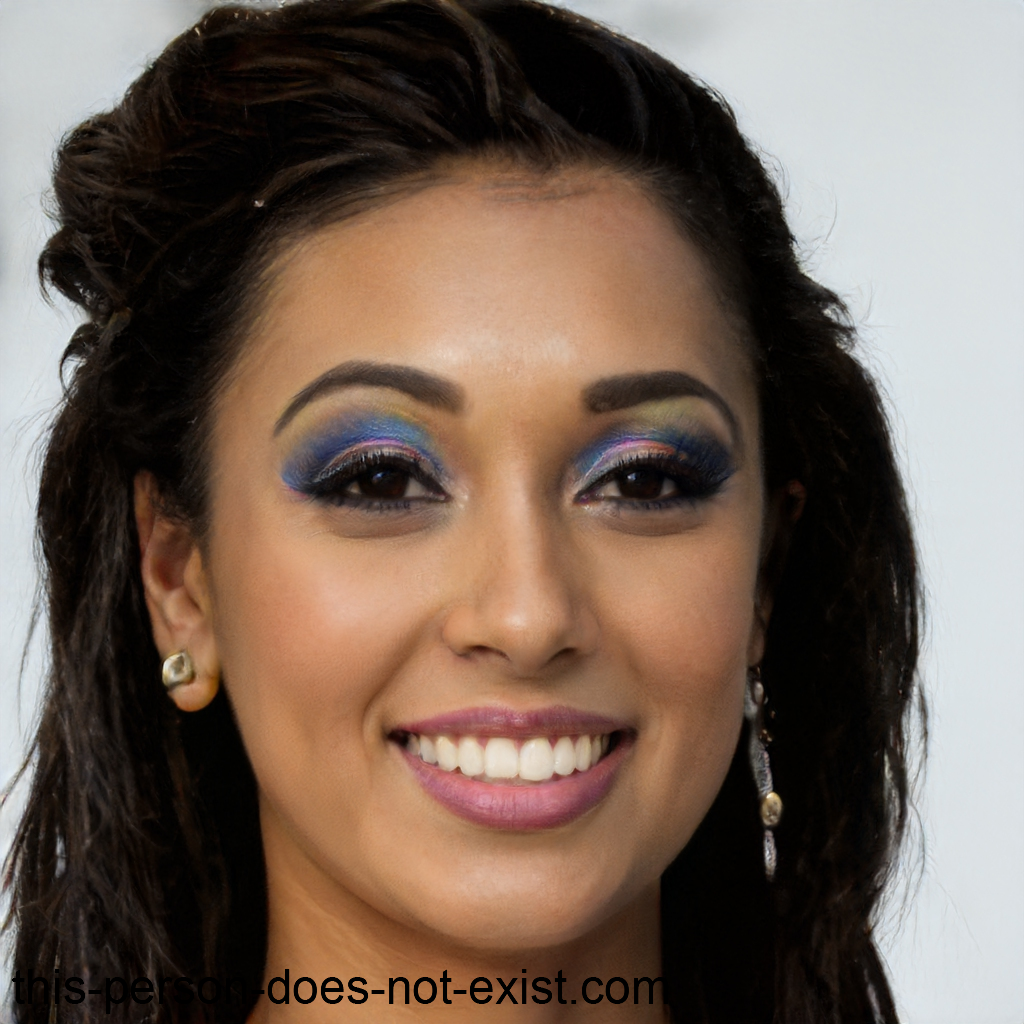



3 = happy
1/1 [==============================] - 0s 25ms/step


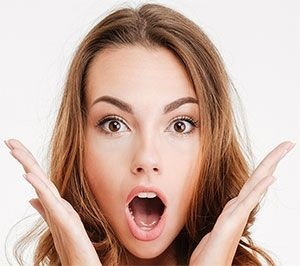



6 = neutral
1/1 [==============================] - 0s 26ms/step


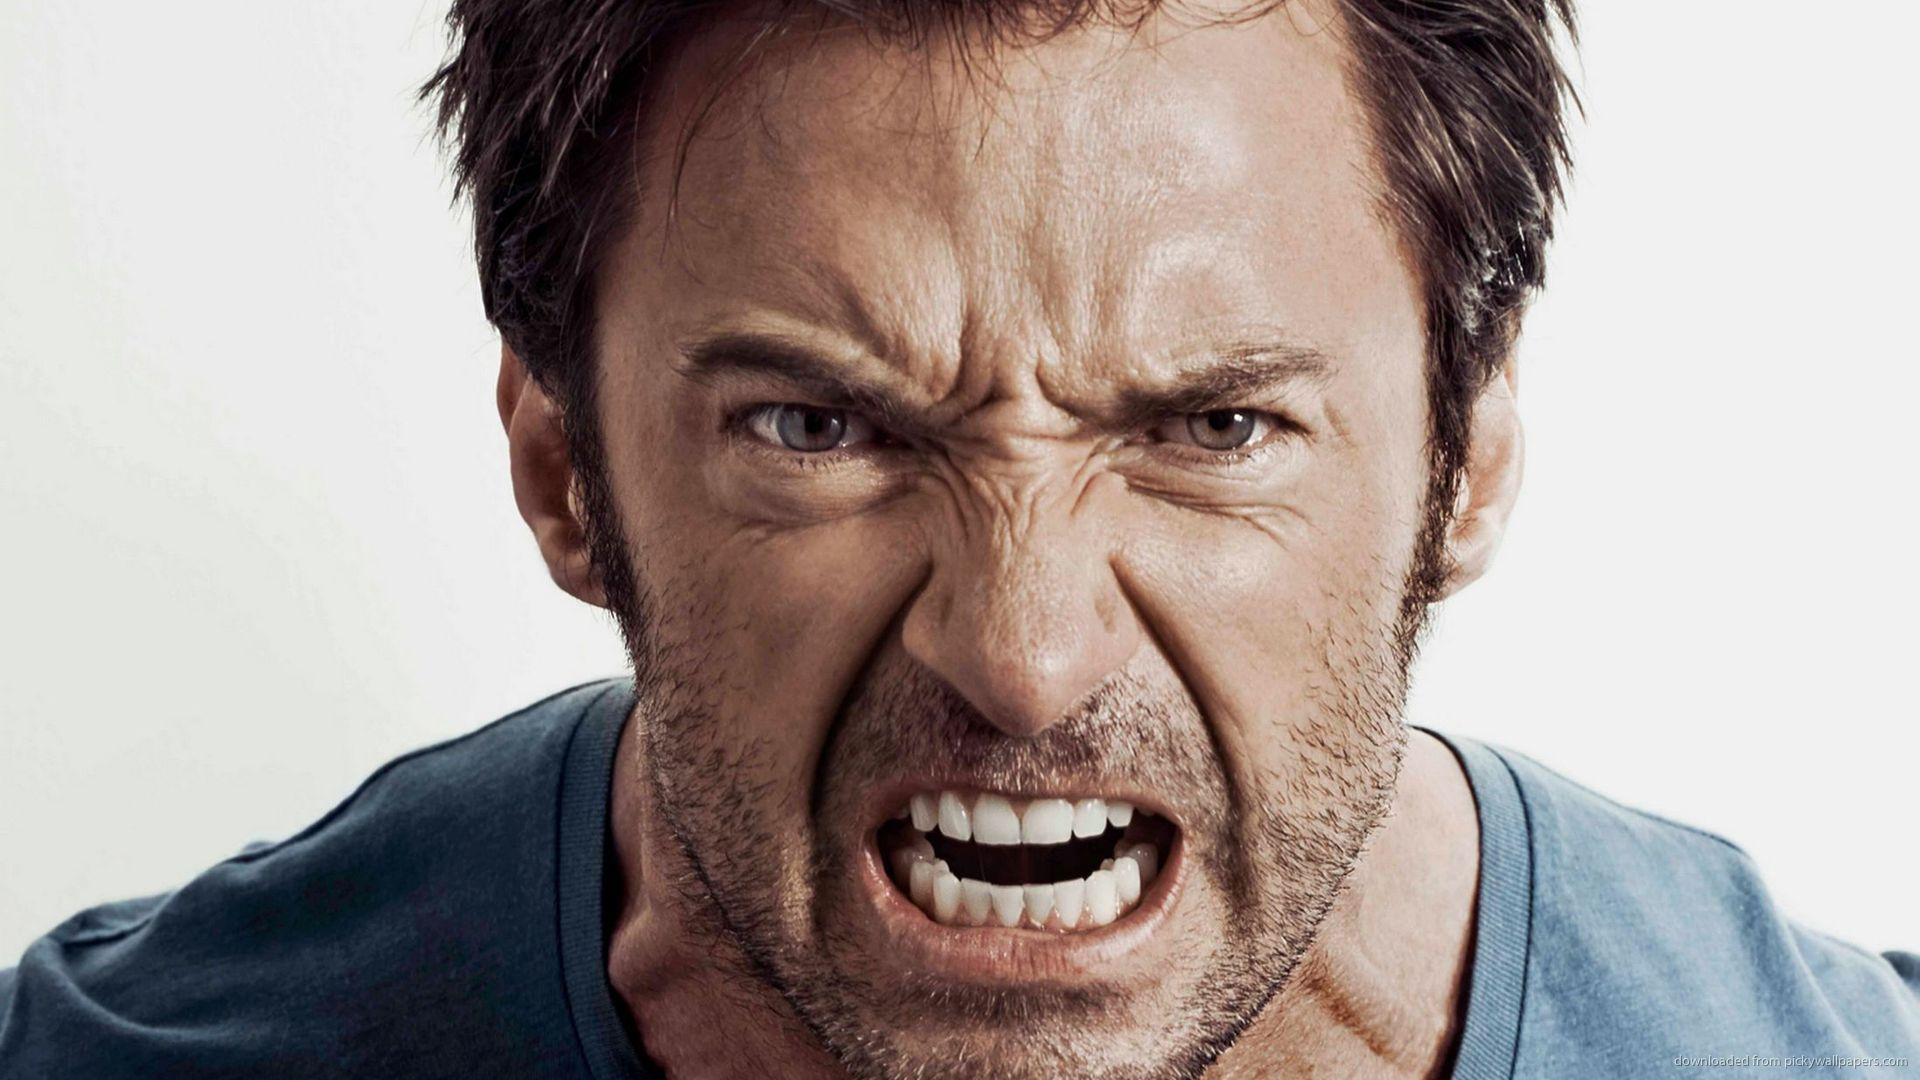



6 = neutral
1/1 [==============================] - 0s 24ms/step


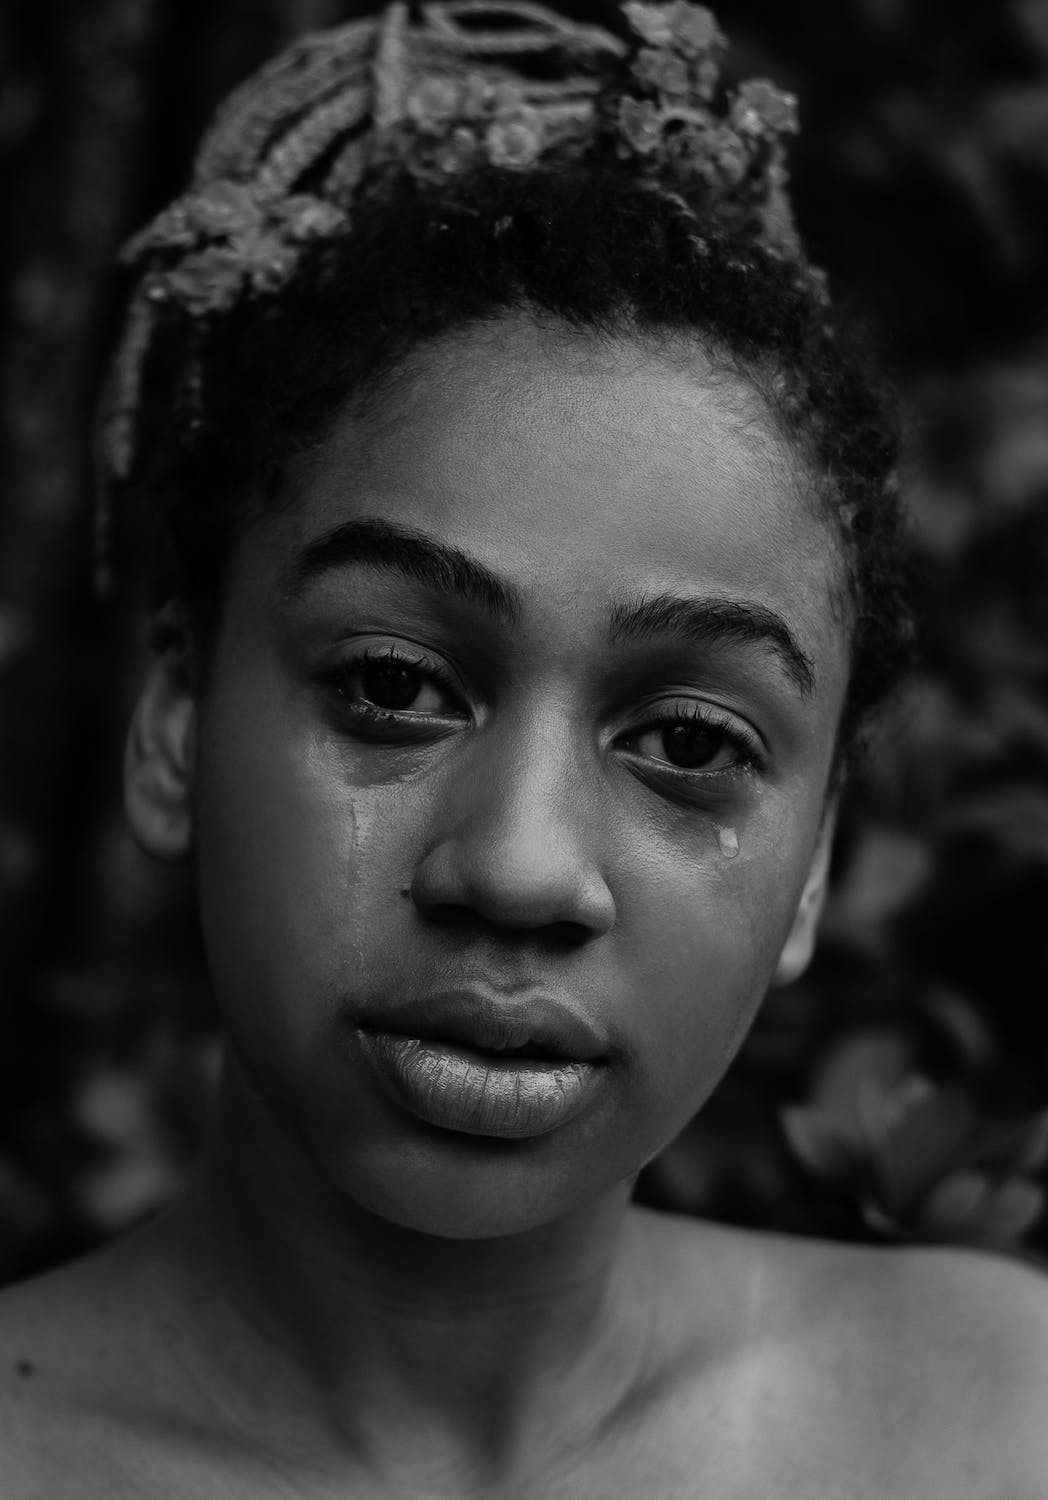



6 = neutral
1/1 [==============================] - 0s 24ms/step


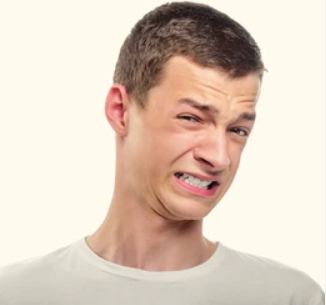



6 = neutral
1/1 [==============================] - 0s 25ms/step


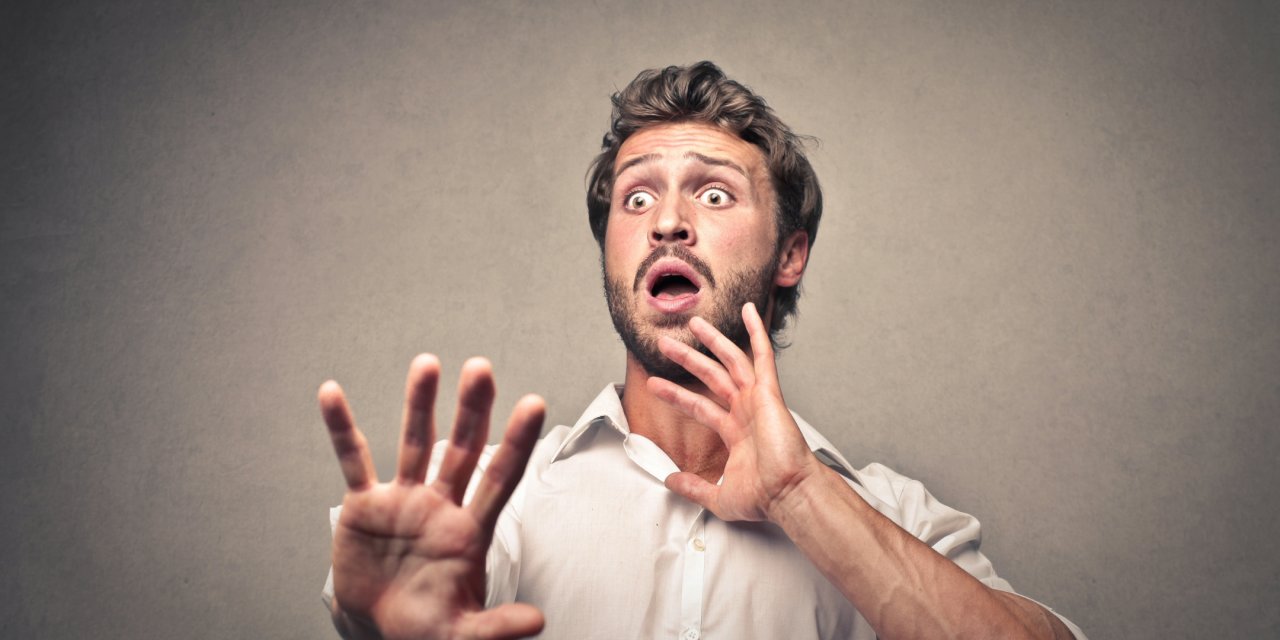



6 = neutral
1/1 [==============================] - 0s 38ms/step


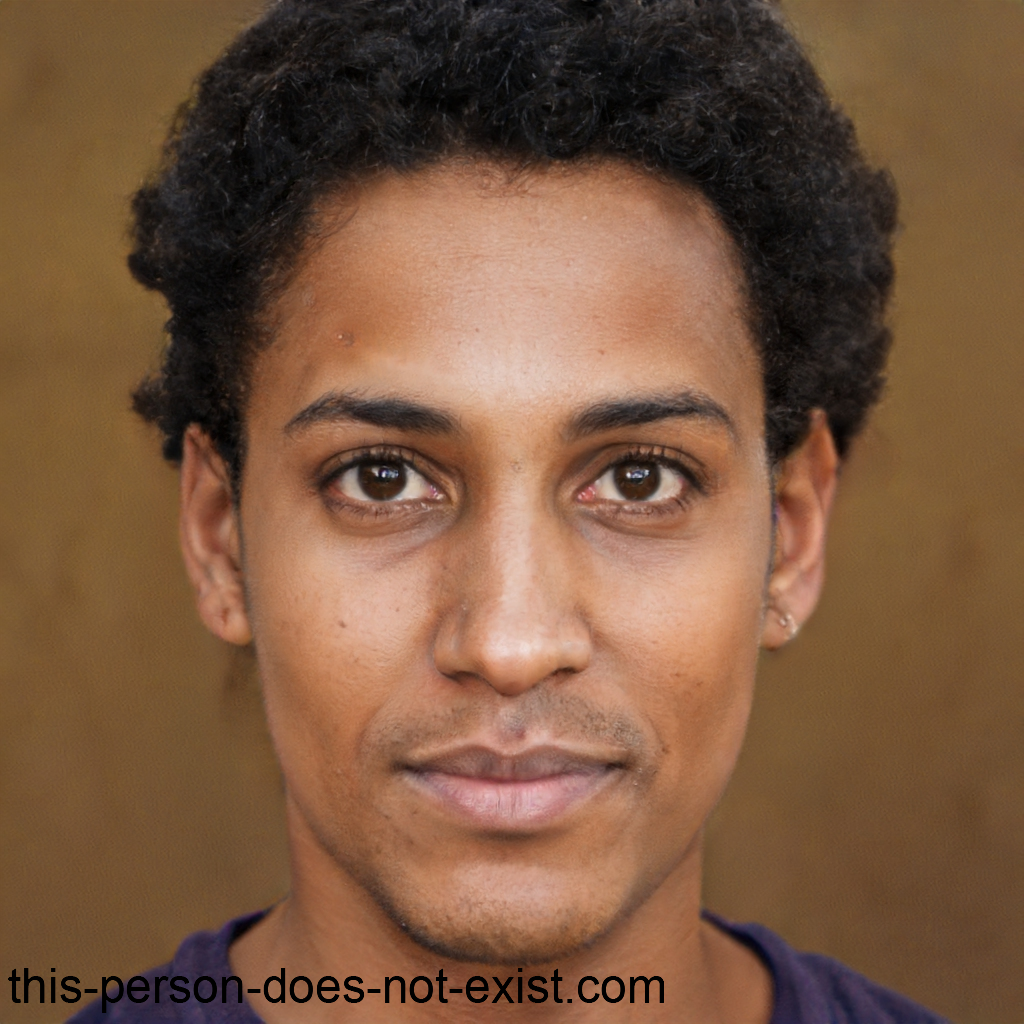



3 = happy
1/1 [==============================] - 0s 36ms/step


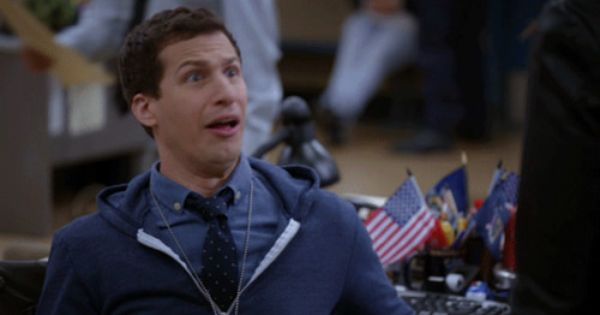



6 = neutral


In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import load_img,img_to_array

TGREEN =  '\033[1;37;42m'
TRED =    '\033[1;37;41m'
TYELLOW = '\033[0;43m'
data_array = []
lables = []
for i in range (1,9):
  img_directory = '/content/drive/MyDrive/photos/'+str(i)+'.png'
  img_data = load_img(img_directory, target_size = (48, 48))   #load the image from the directory
  img_data = img_to_array(img_data)                            #convert the image to a Numpy array
  img_data = tf.image.rgb_to_grayscale(img_data)


  #print(img_data.shape)
  #img_data = np.array(img_data, 'float32')
  #img_data.resize(48,48,1)
  #print(img_data.shape)
  img_data = np.expand_dims(img_data, axis = 0)                     #expands the array by inserting a new axis at the specified position.
  #print(img_data.shape)

  classify = model.predict(img_data)
  display(Image(img_directory,width= 150, height=150))
  print("\n")
  max_index = np.argmax(classify[0])
  emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'neutral')
  emotion_prediction = emotion_detection[max_index]  
  if(max_index == 3 or max_index == 5):
    print(TGREEN + str(max_index) + ' = ' +  emotion_prediction)
  elif(max_index == 4 or max_index == 2 or max_index == 0):
    print(TRED + str(max_index) + ' = ' +  emotion_prediction)
  else:
    print(TYELLOW + str(max_index) + ' = ' +  emotion_prediction)
 


# Saving the model

Third section is for saving the weights of the neural network into a file so we wouldn't have to train the model every time we use the face recognition

We will serialize the model to JSON and save the model's weights in a hd5 file, so we can use it to make predictions directly without retraining the model everytime.



In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/new-model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("/content/drive/MyDrive/new-model.h5")

print("Saved model to drive - file can be located in the colab notebook inside 'content' folder")

Saved model to drive - file can be located in the colab notebook inside 'content' folder


In [ ]:
# Save arrays to disk
np.save('combined_X.npy', combined_X)
np.save('combined_y.npy', combined_y)

# Load arrays from disk
loaded_arr1 = np.load('combined_X.npy')
loaded_arr2 = np.load('combined_y.npy')

# Verify that the loaded arrays match the original arrays
assert np.array_equal(combined_X, loaded_arr1)
assert np.array_equal(combined_y, loaded_arr2)